Daniel, Harry, and Ryan's Business Analytics Solution

# Defining your problem:
- As a Data Analyst at *NY Local Grocery*, you are asked to set accurate weekly inventory values for each produce product for 12 weeks in the Summer
- ...

---

# Download the data

- download the training data as an Excel file: https://docs.google.com/spreadsheets/d/1Fd9UNaKJgxR9XZTa6AT6i4ly3S7TflBU/edit?usp=drive_link&ouid=106212343918359833524&rtpof=true&sd=true
- download the testing data as a CSV: https://drive.google.com/file/d/1FGnDLi5ntXQ9Z7vL36PBNjH_joeAGgQz/view?usp=drive_link
- load each file into your Google Colab files

## Import training data

In [ ]:
# Import all the necessary packages
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import seaborn as sns

In [ ]:
# Load the training data
sales_data = pd.read_excel(r"/content/grocery_data_V1.xlsx", sheet_name = "sales")
stores_data = pd.read_excel(r"/content/grocery_data_V1.xlsx", sheet_name = "stores")
products_data = pd.read_excel(r"/content/grocery_data_V1.xlsx", sheet_name = "products")

In [ ]:
# Print the shape of the data
for dataset in [sales_data, stores_data, products_data]:
  print(f"shape: {dataset.shape}")

shape: (59584, 5)
shape: (7, 4)
shape: (7, 3)


---

## Merge your training data into a single DataFrame

In [ ]:
# Merge the training datasets and print a header
training_data = sales_data.merge(stores_data, right_on = 'store_name', left_on = 'store_name')
training_data = training_data.merge(products_data, right_on = 'product_name', left_on = 'product_name')
training_data.head()

,date,store_name,product_name,BOD_inventory,sales_units,store_number,store_county,store_size,product_number,product_category
0,2016-01-03,Garden City,banana,400,60,1,Nassau County,25178,1,fruit
1,2016-01-04,Garden City,banana,340,68,1,Nassau County,25178,1,fruit
2,2016-01-05,Garden City,banana,272,63,1,Nassau County,25178,1,fruit
3,2016-01-06,Garden City,banana,209,69,1,Nassau County,25178,1,fruit
4,2016-01-07,Garden City,banana,140,68,1,Nassau County,25178,1,fruit


In [ ]:
# Convert dates to date-time as part of feature engineering
training_data['day_number'] = training_data['date'].dt.day
training_data['week_number'] = training_data['date'].dt.week
training_data['month_number'] = training_data['date'].dt.month
training_data['year_number'] = training_data['date'].dt.year
training_data['week_day'] = training_data['date'].dt.weekday
date = training_data['date']
#training_data = training_data.drop(columns = ["date"])
training_data.head(7)

<ipython-input-5-7f44f3605946>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  training_data['week_number'] = training_data['date'].dt.week


,date,store_name,product_name,BOD_inventory,sales_units,store_number,store_county,store_size,product_number,product_category,day_number,week_number,month_number,year_number,week_day
0,2016-01-03,Garden City,banana,400,60,1,Nassau County,25178,1,fruit,3,53,1,2016,6
1,2016-01-04,Garden City,banana,340,68,1,Nassau County,25178,1,fruit,4,1,1,2016,0
2,2016-01-05,Garden City,banana,272,63,1,Nassau County,25178,1,fruit,5,1,1,2016,1
3,2016-01-06,Garden City,banana,209,69,1,Nassau County,25178,1,fruit,6,1,1,2016,2
4,2016-01-07,Garden City,banana,140,68,1,Nassau County,25178,1,fruit,7,1,1,2016,3
5,2016-01-08,Garden City,banana,72,72,1,Nassau County,25178,1,fruit,8,1,1,2016,4
6,2016-01-09,Garden City,banana,0,0,1,Nassau County,25178,1,fruit,9,1,1,2016,5


---

In [ ]:
# Convert the training data categorical variables to object data types
training_data[['store_number', 'store_county','product_number',
       'product_category']]= training_data[['store_number', 'store_county','product_number',
       'product_category']].astype(object)

# EDA
- Data types
- Null values
- Duplicate values

In [ ]:
# Create a data profiling function
def create_data_profiling_df(data: pd.DataFrame) -> pd.DataFrame:

    # Create an empty dataframe to gather information about each column
    data_profiling_df = pd.DataFrame(columns = ["column_name",
                                                "column_type",
                                                "unique_values",
                                                "duplicate_values",
                                                "null_values",
                                                "mean",
                                                "std",
                                                "CV",
                                                "kurtosis",
                                                "skew",
                                                "median",
                                                "max",
                                                "min",
                                                "range",
                                                "IQR",
                                                "extreme_values_std",
                                               "extreme_values_quartiles"])

    # Loop through each column to add rows to the data_profiling_df dataframe
    for column in data.columns:

        # Create an empty dictionary to store the columns data
        column_dict = {}

        try:
            column_dict["column_name"] = [column]
            column_dict["column_type"] = [data[column].dtypes]
            column_dict["unique_values"] = [len(data[column].unique())]
            column_dict["duplicate_values"] = [(data[column].shape[0] - data[column].isna().sum()) - len(data[column].unique())]
            column_dict["null_values"] = [data[column].isna().sum()]
            column_dict['mean'] = [data[column].mean() if (data[column].dtypes != object) else "NA"]
            column_dict['std'] = [data[column].std() if (data[column].dtypes != object) else "NA"]
            column_dict['CV'] = [data[column].std()/data[column].mean() if (data[column].dtypes != object) else "NA"]
            column_dict['kurtosis'] = [data[column].kurtosis() if (data[column].dtypes != object) else "NA"]
            column_dict['skew'] = [data[column].skew() if (data[column].dtypes != object) else "NA"]
            mean_column = data[column].mean()
            std_column = data[column].std()
            column_dict['extreme_values_std'] = [((data[column] < (mean_column - 3 * std_column)) | (data[column] > (mean_column + 3 * std_column))).sum() if (data[column].dtypes != object) else "NA"]
            column_dict['median'] = [data[column].median() if (data[column].dtypes != object) else "NA"]
            column_dict["max"] = [data[column].max() if (data[column].dtypes != object) else "NA"]
            column_dict["min"] = [data[column].min() if (data[column].dtypes != object) else "NA"]
            column_dict["range"] = [data[column].max() - data[column].min() if (data[column].dtypes != object) else "NA"]
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            column_dict["IQR"] = [IQR if (data[column].dtypes != object) else "NA"]
            column_dict['extreme_values_quartiles'] = [((data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))).sum() if (data[column].dtypes != object) else "NA"]

        except:
            print(f"unable to read column: {column}, you may want to drop this column")

        # Add the information from the columns dict to the final dataframe
        data_profiling_df = pd.concat([data_profiling_df, pd.DataFrame(column_dict)],
                                      ignore_index = True)

    # Sort the final dataframe by unique values descending
    data_profiling_df.sort_values(by = ['unique_values'],
                                  ascending = [False],
                                  inplace=True)

    # Print the function is complete
    print(f"data profiling complete, dataframe contains {len(data_profiling_df)} columns")
    return data_profiling_df

In [ ]:
# Run the data profiling function and print the dataframe
data_profiling_df = create_data_profiling_df(data = training_data)
data_profiling_df

unable to read column: date, you may want to drop this column
unable to read column: store_name, you may want to drop this column
unable to read column: product_name, you may want to drop this column
unable to read column: store_county, you may want to drop this column
unable to read column: product_category, you may want to drop this column
data profiling complete, dataframe contains 15 columns


,column_name,column_type,unique_values,duplicate_values,null_values,mean,std,CV,kurtosis,skew,median,max,min,range,IQR,extreme_values_std,extreme_values_quartiles
0,date,datetime64[ns],1216,58368,0,2017-09-01 12:00:00,351 days 00:45:46.713830644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BOD_inventory,int64,394,59190,0,255.052413,121.329587,0.475705,-0.564184,-0.702993,285.0,400,0,400,174.0,0,0
4,sales_units,int64,146,59438,0,42.726101,25.254665,0.591083,0.201202,0.56224,40.0,147,0,147,34.0,330,639
11,week_number,int64,53,59531,0,24.78125,15.246779,0.615255,-1.22761,0.160603,24.0,53,1,52,27.0,0,0
10,day_number,int64,31,59553,0,15.712171,8.791482,0.559533,-1.193047,0.007553,16.0,31,1,30,15.0,0,0
12,month_number,int64,12,59572,0,6.131579,3.499201,0.570685,-1.238949,0.149566,6.0,12,1,11,6.0,0,0
1,store_name,object,7,59577,0,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,7,59577,0,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,store_number,object,7,59577,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,store_size,int64,7,59577,0,38617.714286,10715.032789,0.277464,-0.79329,0.468004,36735.0,58306,25178,33128,18094.0,0,0


array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'BOD_inventory'}>,
        <Axes: title={'center': 'sales_units'}>],
       [<Axes: title={'center': 'store_size'}>,
        <Axes: title={'center': 'day_number'}>,
        <Axes: title={'center': 'week_number'}>],
       [<Axes: title={'center': 'month_number'}>,
        <Axes: title={'center': 'year_number'}>,
        <Axes: title={'center': 'week_day'}>]], dtype=object)

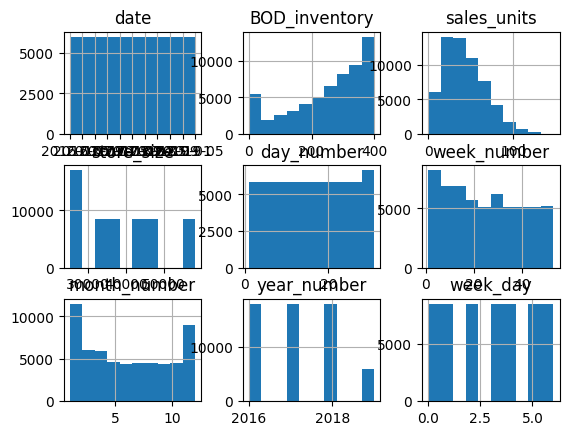

In [ ]:
# produce histograms of training dataset quantitative variables
training_data.hist()

## Further Exploration

In [ ]:
# Plots of the dataset

<ipython-input-12-5c3c97cc247c>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)


<Axes: xlabel='month_number', ylabel='sales_units'>

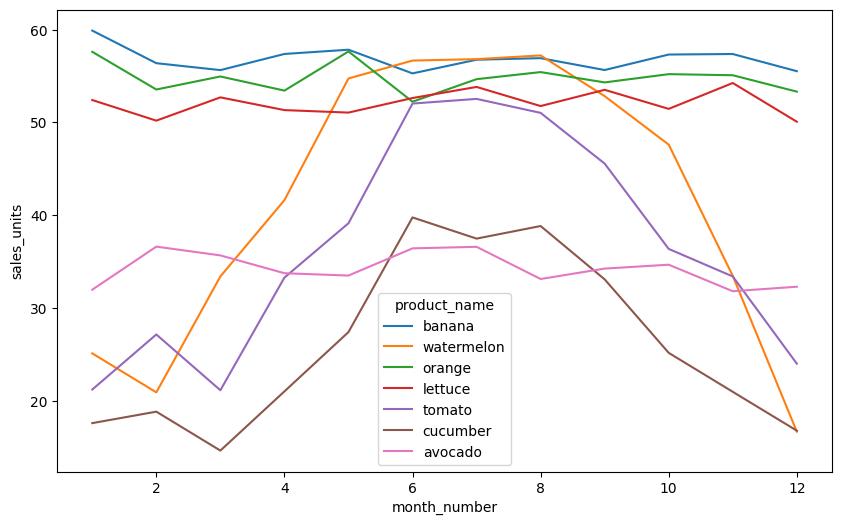

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)

<ipython-input-13-5afb497b2b7b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'product_category', data = training_data, ci=None)


<Axes: xlabel='month_number', ylabel='sales_units'>

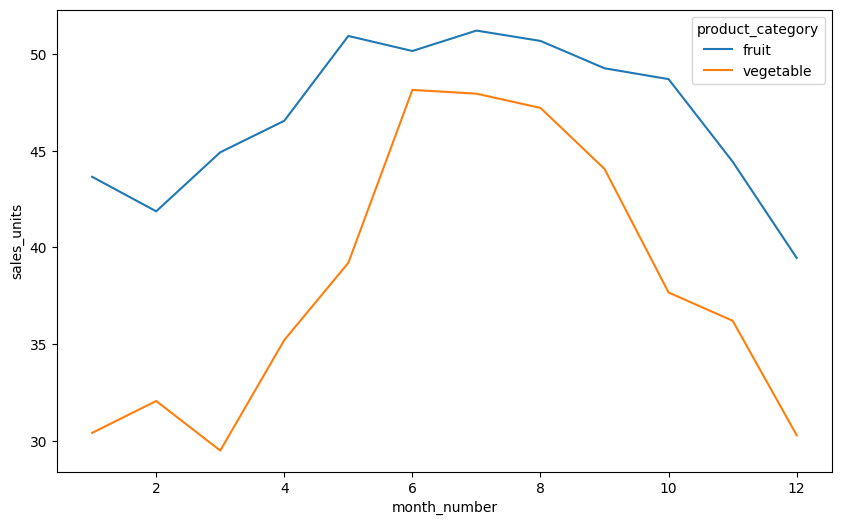

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'product_category', data = training_data, ci=None)

<ipython-input-14-dafaa1f7849b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'store_number', data = training_data, ci=None)


<Axes: xlabel='month_number', ylabel='sales_units'>

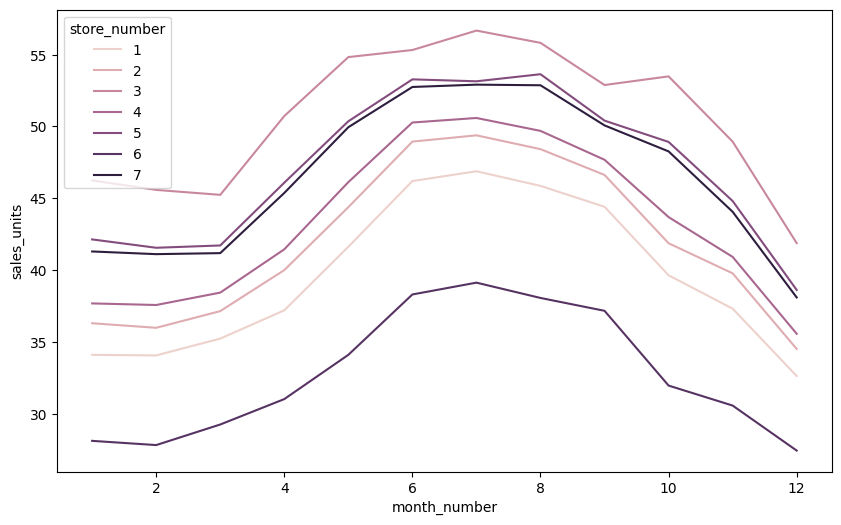

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'month_number', y = 'sales_units', hue= 'store_number', data = training_data, ci=None)

<ipython-input-15-1d6e6dbf44b9>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'week_number', y = 'sales_units', hue= 'store_number', data = training_data, ci=None)


<Axes: xlabel='week_number', ylabel='sales_units'>

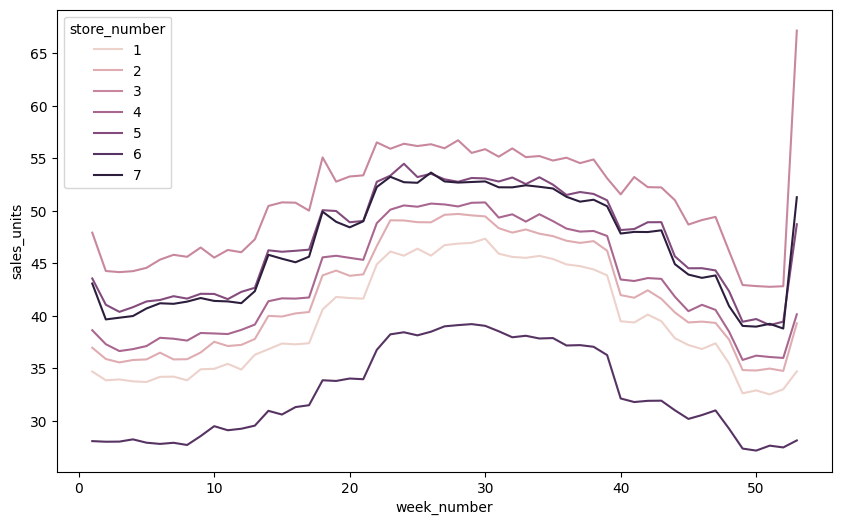

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'week_number', y = 'sales_units', hue= 'store_number', data = training_data, ci=None)

<ipython-input-16-f494286a2d21>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'year_number', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)


<Axes: xlabel='year_number', ylabel='sales_units'>

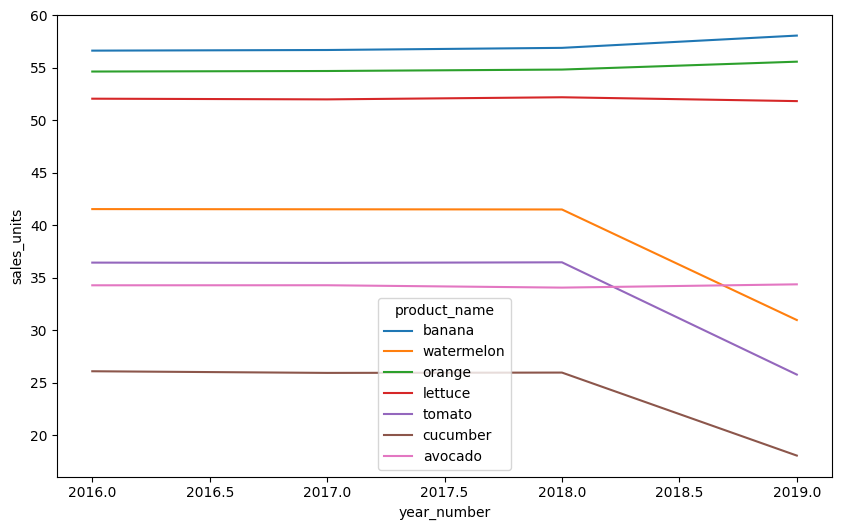

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'year_number', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)

<ipython-input-17-b9c62f239e2a>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = 'week_day', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)


<Axes: xlabel='week_day', ylabel='sales_units'>

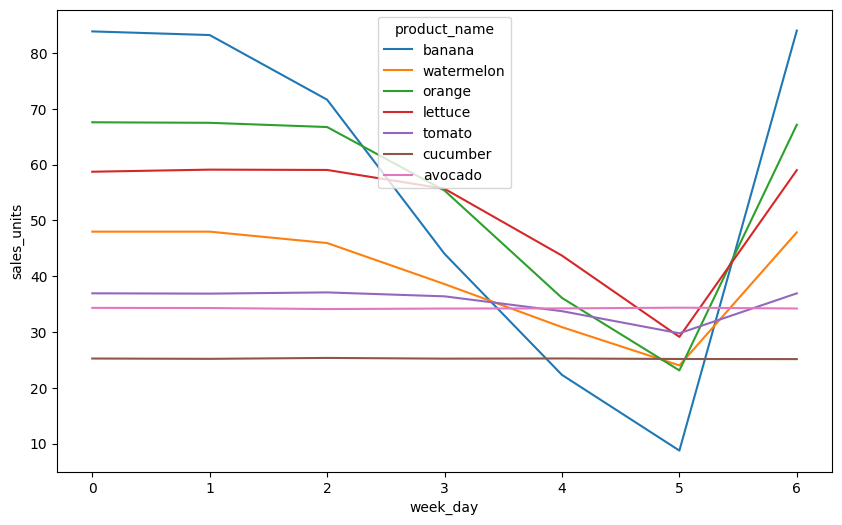

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x = 'week_day', y = 'sales_units', hue= 'product_name', data = training_data, ci=None)

# Feature Engineeering

In [ ]:
# Split the data to two datasets days with demand == 0 and demand > 0
data_to_fit = training_data[training_data['BOD_inventory']==training_data['sales_units']]
data_to_train = training_data.drop(data_to_fit.index)

In [ ]:
# Create demand column on training dataset
data_to_train["demand"] = data_to_train['sales_units']

In [ ]:
# Encoding day of week as an angular function
'''
data_to_train['week_day_sin'] = np.sin(data_to_train['week_day'] * (2 * np.pi / 7))
data_to_train['week_day_cos'] = np.cos(data_to_train['week_day'] * (2 * np.pi / 7))
data_to_train.drop(columns = ['week_day'], inplace = True)

data_to_train['week_number_sin'] = np.sin(data_to_train['week_number'] * (2 * np.pi / 53))
data_to_train['week_number_cos'] = np.cos(data_to_train['week_number'] * (2 * np.pi / 53))
data_to_train.drop(columns = ['week_number'], inplace = True)

data_to_train['month_number_sin'] = np.sin(data_to_train['month_number'] * (2 * np.pi / 12))
data_to_train['month_number_cos'] = np.cos(data_to_train['month_number'] * (2 * np.pi / 12))
data_to_train.drop(columns = ['month_number'], inplace = True)'''

"\ndata_to_train['week_day_sin'] = np.sin(data_to_train['week_day'] * (2 * np.pi / 7))\ndata_to_train['week_day_cos'] = np.cos(data_to_train['week_day'] * (2 * np.pi / 7))\ndata_to_train.drop(columns = ['week_day'], inplace = True)\n\ndata_to_train['week_number_sin'] = np.sin(data_to_train['week_number'] * (2 * np.pi / 53))\ndata_to_train['week_number_cos'] = np.cos(data_to_train['week_number'] * (2 * np.pi / 53))\ndata_to_train.drop(columns = ['week_number'], inplace = True)\n\ndata_to_train['month_number_sin'] = np.sin(data_to_train['month_number'] * (2 * np.pi / 12))\ndata_to_train['month_number_cos'] = np.cos(data_to_train['month_number'] * (2 * np.pi / 12))\ndata_to_train.drop(columns = ['month_number'], inplace = True)"

In [ ]:
# Encoding day of week as an angular function
'''
data_to_fit['week_day_sin'] = np.sin(data_to_fit['week_day'] * (2 * np.pi / 7))
data_to_fit['week_day_cos'] = np.cos(data_to_fit['week_day'] * (2 * np.pi / 7))
data_to_fit.drop(columns = ['week_day'], inplace = True)

data_to_fit['week_number_sin'] = np.sin(data_to_fit['week_number'] * (2 * np.pi / 53))
data_to_fit['week_number_cos'] = np.cos(data_to_fit['week_number'] * (2 * np.pi / 53))
data_to_fit.drop(columns = ['week_number'], inplace = True)

data_to_fit['month_number_sin'] = np.sin(data_to_fit['month_number'] * (2 * np.pi / 12))
data_to_fit['month_number_cos'] = np.cos(data_to_fit['month_number'] * (2 * np.pi / 12))
data_to_fit.drop(columns = ['month_number'], inplace = True)'''

"\ndata_to_fit['week_day_sin'] = np.sin(data_to_fit['week_day'] * (2 * np.pi / 7))\ndata_to_fit['week_day_cos'] = np.cos(data_to_fit['week_day'] * (2 * np.pi / 7))\ndata_to_fit.drop(columns = ['week_day'], inplace = True)\n\ndata_to_fit['week_number_sin'] = np.sin(data_to_fit['week_number'] * (2 * np.pi / 53))\ndata_to_fit['week_number_cos'] = np.cos(data_to_fit['week_number'] * (2 * np.pi / 53))\ndata_to_fit.drop(columns = ['week_number'], inplace = True)\n\ndata_to_fit['month_number_sin'] = np.sin(data_to_fit['month_number'] * (2 * np.pi / 12))\ndata_to_fit['month_number_cos'] = np.cos(data_to_fit['month_number'] * (2 * np.pi / 12))\ndata_to_fit.drop(columns = ['month_number'], inplace = True)"

In [ ]:
# Dropping unnecessary columns for the machine learning algorithm - feature engineering
columns_to_drop = ['date','store_number','product_number', 'product_category','store_county','sales_units','day_number', 'month_number']
data_to_fit.drop(columns = columns_to_drop, inplace = True)
data_to_train.drop(columns = columns_to_drop, inplace = True)

<ipython-input-22-551dad19f779>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_fit.drop(columns = columns_to_drop, inplace = True)


In [ ]:
# Define columns for different preprocessing steps
numeric_cols = ['BOD_inventory','store_size','year_number','week_day','week_number']
nominal_cols = ['store_name', 'product_name']

In [ ]:
# Created a pipeline
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_cols),
        ('nominal_transformer', nominal_transformer, nominal_cols)])

In [ ]:
# Data Split
X = data_to_train.drop(columns = ['demand'])
y = data_to_train['demand']

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (36936, 7)
Test shape: (15830, 7)


# Fit regression model

In [ ]:
# Import the packages for the regression model and define the function to print the metrics
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from warnings import simplefilter
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Linear Regression

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


explained_variance:  0.7334
r2:  0.7334
MAE:  8.8225
MSE:  144.9515
RMSE:  12.0396
explained_variance:  0.7273
r2:  0.7273
MAE:  8.8894
MSE:  148.1898
RMSE:  12.1733


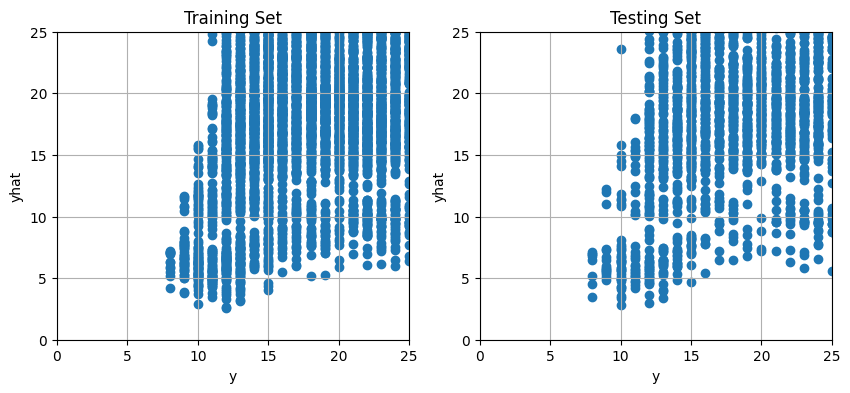

In [ ]:
#Fit the linear regression model using the pipeline
model = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('model', LinearRegression())])

model.fit(X_train,y_train)

# Predictions on the validation set
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

regression_results(y_train,y_pred_train)
regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,25)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(0,25)
ax[1].set_xlim(0,25)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')
plt.show()

In [ ]:
# Get pipeline feature names in order of importance
feature_names = model[:-1].get_feature_names_out()
feature_importance = pd.DataFrame()
feature_importance['features'] = feature_names
feature_importance['weighted_coefficeints'] = model.named_steps['model'].coef_
feature_importance['coef_abs'] = feature_importance['weighted_coefficeints'].abs()
feature_importance.sort_values(ascending=False, by = ['coef_abs'])



,features,weighted_coefficeints,coef_abs
11,nominal_transformer__product_name_banana,46.004165,46.004165
14,nominal_transformer__product_name_orange,30.924582,30.924582
13,nominal_transformer__product_name_lettuce,23.191970,23.191970
7,nominal_transformer__store_name_Oceanside,15.056238,15.056238
8,nominal_transformer__store_name_Rye,-13.197711,13.197711
16,nominal_transformer__product_name_watermelon,9.512660,9.512660
12,nominal_transformer__product_name_cucumber,-8.584273,8.584273
1,numeric_transformer__store_size,6.356709,6.356709
9,nominal_transformer__store_name_Sleepy Hollow,-5.435288,5.435288
5,nominal_transformer__store_name_Greenport,3.843976,3.843976


## Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


explained_variance:  0.9935
r2:  0.9935
MAE:  1.3957
MSE:  3.5539
RMSE:  1.8852
explained_variance:  0.9525
r2:  0.9525
MAE:  3.8018
MSE:  25.8213
RMSE:  5.0815


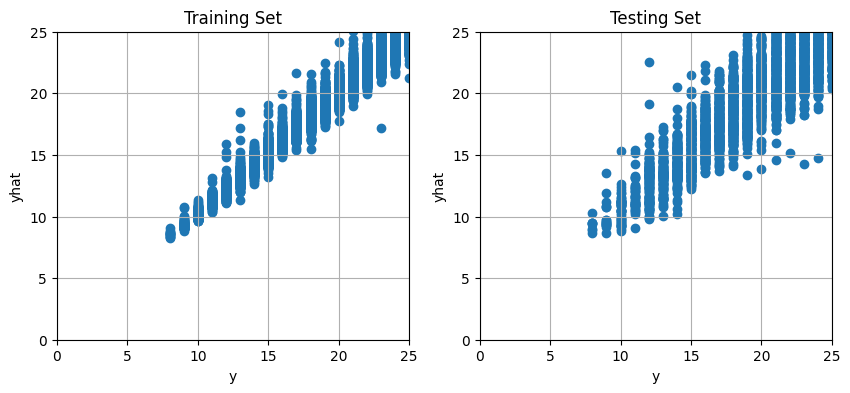

In [ ]:
#Import the packages necessary for random forests
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

rf.fit(X_train,y_train)

# Predictions on the validation set
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

regression_results(y_train,y_pred_train)
regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,25)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(0,25)
ax[1].set_xlim(0,25)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')
plt.show()

### Random Forest Feature Importance

In [ ]:
# Get pipeline feature names in order of importance
feature_names_rf = model[:-1].get_feature_names_out()
feature_importance_rf = pd.DataFrame()
feature_importance_rf['features'] = feature_names_rf
feature_importance_rf['weighted_coefficeints_rf'] = rf.named_steps['model'].feature_importances_
feature_importance_rf.sort_values(ascending=False, by = ['weighted_coefficeints_rf'])

,features,weighted_coefficeints_rf
11,nominal_transformer__product_name_banana,0.229530
1,numeric_transformer__store_size,0.192690
4,numeric_transformer__week_number,0.133898
14,nominal_transformer__product_name_orange,0.132918
13,nominal_transformer__product_name_lettuce,0.103858
0,numeric_transformer__BOD_inventory,0.053671
16,nominal_transformer__product_name_watermelon,0.048018
8,nominal_transformer__store_name_Rye,0.032888
3,numeric_transformer__week_day,0.018922
15,nominal_transformer__product_name_tomato,0.016375


## XGBoost

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


explained_variance:  0.9681
r2:  0.9681
MAE:  3.2187
MSE:  17.3284
RMSE:  4.1627
explained_variance:  0.9568
r2:  0.9568
MAE:  3.698
MSE:  23.4991
RMSE:  4.8476


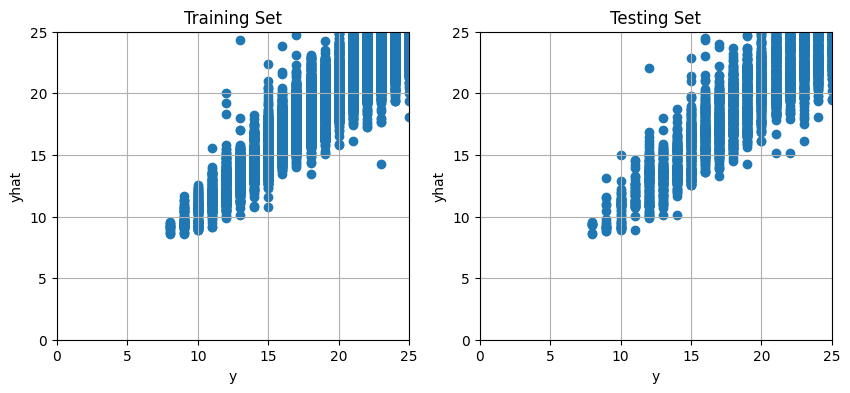

In [ ]:
#Import the packages necessary for XGBoost
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score

XGB = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('XGB', XGBRegressor(random_state=0))])

XGB.fit(X_train,y_train)

# Predictions on the validation set
y_pred_test = XGB.predict(X_test)
y_pred_train = XGB.predict(X_train)

regression_results(y_train,y_pred_train)
regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,25)
ax[0].set_xlim(0,25)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(0,25)
ax[1].set_xlim(0,25)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')
plt.show()

In [ ]:
#Fit the XGBoost model to predict demand
demand_fitted = XGB.predict(data_to_fit)
data_to_fit['demand'] = demand_fitted

<ipython-input-33-8531eb32192e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_fit['demand'] = demand_fitted


## Merge data_to_train and data_to_fit and Aggregate dataframe

In [ ]:
#Merge the datasets to fill in the values we thought were faulty (where sales units = inventory units)
demand_predicted = data_to_train.append(data_to_fit)['demand']
final_training_data = training_data.merge(demand_predicted, left_index=True, right_index=True)
final_training_data.set_index('date', inplace=True, drop=True)

<ipython-input-34-9760b202b5c9>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  demand_predicted = data_to_train.append(data_to_fit)['demand']


In [ ]:
#Aggregate the data
ag = final_training_data.groupby(['store_county','store_name','product_name',	'product_category']).resample('W-SAT').agg({'store_size':'max', 'demand':'sum','week_number':'max','month_number':'max'})
ag.reset_index(inplace=True)

In [ ]:
ag

,store_county,store_name,product_name,product_category,date,store_size,demand,week_number,month_number
0,Nassau County,Garden City,avocado,fruit,2016-01-09,25178,187.0,53,1
1,Nassau County,Garden City,avocado,fruit,2016-01-16,25178,182.0,2,1
2,Nassau County,Garden City,avocado,fruit,2016-01-23,25178,184.0,3,1
3,Nassau County,Garden City,avocado,fruit,2016-01-30,25178,181.0,4,1
4,Nassau County,Garden City,avocado,fruit,2016-02-06,25178,200.0,5,2
...,...,...,...,...,...,...,...,...,...
8521,Westchester,Sleepy Hollow,watermelon,fruit,2019-04-06,58306,342.0,14,4
8522,Westchester,Sleepy Hollow,watermelon,fruit,2019-04-13,58306,319.0,15,4
8523,Westchester,Sleepy Hollow,watermelon,fruit,2019-04-20,58306,320.0,16,4
8524,Westchester,Sleepy Hollow,watermelon,fruit,2019-04-27,58306,338.0,17,4


In [ ]:
#Drop unnecessary columns and refine the ag dataset
ag = ag.drop(columns = ['date']).reindex(columns =['week_number', 'month_number', 'store_size', 'store_county', 'store_name',
       'product_name', 'product_category', 'demand'])
ag.columns = ['week', 'month', 'store_size', 'store_county', 'store_name',
       'product_name', 'product_category', 'sd']

## Import testing data

In [ ]:
testing_data = pd.read_csv(r"/content/grocery_testing_data.csv")

In [ ]:
testing_data.head(3)

,date,store_name,product_name,sd
0,2020-06-06,Garden City,avocado,194
1,2020-06-13,Garden City,avocado,213
2,2020-06-20,Garden City,avocado,211


### Your prediction dataframe must look like:

grain: each row in your dataframe will be one product, at one store, for one week.
You must include every week number from starting on 6/6/2020 to 8/22/2020:
- weeks [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

| column | description |
| ----------- | ----------- |
| week | week of year (from 1-53) |
| month | month of year (from 1-12) |
| store_name | name of the store |
| store_county | county of store |
| store_size | size of store in square feet |
| product_name | name of the product |
| product_category | category of the product: fruit or vegetable |
| sales_demand | the ideal inventory level of the product |

In [ ]:
testing_data.columns

Index(['date', 'store_name', 'product_name', 'sd'], dtype='object')

In [ ]:
testing_data["date"] = pd.to_datetime(testing_data["date"])
testing_data = testing_data.merge(stores_data,
                                on = "store_name")

testing_data = testing_data.merge(products_data,
                                  on = "product_name")

testing_data['week'] = testing_data["date"].dt.week
testing_data['month'] = testing_data["date"].dt.month

testing_data = testing_data[['week', 'month', 'store_size',
                             'store_county', 'store_name',
                             'product_name', 'product_category',
                             'sd']]

testing_data_X = testing_data.drop('sd', axis=1)
testing_data_y = testing_data['sd']

<ipython-input-41-dd28166870dd>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  testing_data['week'] = testing_data["date"].dt.week


# Evaluation regression model

In [ ]:
# Data Split
X = ag.drop(columns = ['sd'])
y = ag['sd']

In [ ]:
# Drop columns
cols_to_drop = ['store_county','product_category']
testing_data_X = testing_data_X.drop(columns = cols_to_drop)
X = X.drop(columns = cols_to_drop)

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (5968, 5)
Test shape: (2558, 5)


In [ ]:
# define columns for different preprocessing steps
numeric_cols = ['week','month','store_size']
nominal_cols = ['store_name', 'product_name']

In [ ]:
# Define pipelines to conduct feature engineering such as scaling and one-hot-encoding
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_cols),
        ('nominal_transformer', nominal_transformer, nominal_cols)])

### OLS

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training
explained_variance:  0.7865
r2:  0.7865
MAE:  55.5064
MSE:  6225.026
RMSE:  78.8988
Testing
explained_variance:  0.7971
r2:  0.7967
MAE:  53.8834
MSE:  5660.9441
RMSE:  75.2392
Evaluation Data Set
explained_variance:  0.6559
r2:  0.4596
MAE:  86.224
MSE:  13937.5366
RMSE:  118.0573


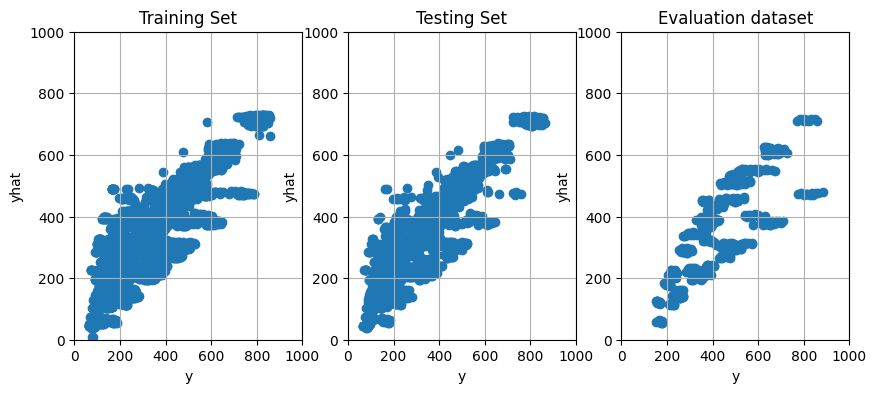

In [ ]:
# Perform OLS regression using a pipeline
ols = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('model', LinearRegression())])

ols.fit(X_train,y_train)

# Predictions on the validation set
# Predictions on the validation set
y_pred_train = ols.predict(X_train)
y_pred_test = ols.predict(X_test)
y_pred_eval = ols.predict(testing_data_X)

# Results
print('Training')
regression_results(y_train,y_pred_train)
print('Testing')
regression_results(y_test,y_pred_test)
print('Evaluation Data Set')
regression_results(testing_data_y,y_pred_eval)
#regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=3, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,1000)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(-0,1000)
ax[1].set_xlim(0,1000)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')

ax[2].scatter(testing_data_y, y_pred_eval)
ax[2].set_ylim(0,1000)
ax[2].set_xlim(0,1000)
ax[2].grid()
ax[2].set_xlabel('y')
ax[2].set_ylabel('yhat')
ax[2].set_title('Evaluation dataset')
plt.show()

### Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training
explained_variance:  0.9955
r2:  0.9955
MAE:  7.1577
MSE:  129.8446
RMSE:  11.3949
Testing
explained_variance:  0.9893
r2:  0.9893
MAE:  11.1959
MSE:  297.7449
RMSE:  17.2553
Evaluation Data Set
explained_variance:  0.9794
r2:  0.976
MAE:  16.6687
MSE:  620.1615
RMSE:  24.903


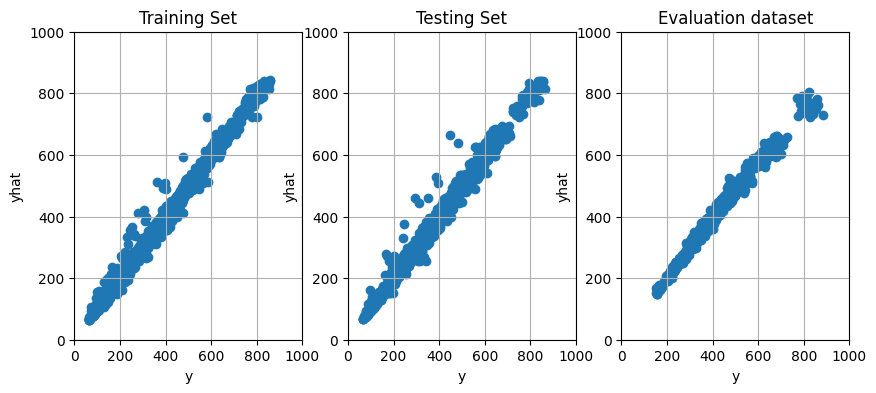

In [ ]:
#Perform random forests using a pipeline
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

rf.fit(X_train,y_train)

# Predictions on the validation set
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
y_pred_eval = rf.predict(testing_data_X)

# Results
print('Training')
regression_results(y_train,y_pred_train)
print('Testing')
regression_results(y_test,y_pred_test)
print('Evaluation Data Set')
regression_results(testing_data_y,y_pred_eval)
#regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=3, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,1000)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(-0,1000)
ax[1].set_xlim(0,1000)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')

ax[2].scatter(testing_data_y, y_pred_eval)
ax[2].set_ylim(0,1000)
ax[2].set_xlim(0,1000)
ax[2].grid()
ax[2].set_xlabel('y')
ax[2].set_ylabel('yhat')
ax[2].set_title('Evaluation dataset')
plt.show()

In [ ]:
#Get pipeline feature names in order of importance
feature_names_rf = rf[:-1].get_feature_names_out()
feature_importance_rf = pd.DataFrame()
feature_importance_rf['features'] = feature_names_rf
feature_importance_rf['weighted_coefficeints_rf'] = rf.named_steps['model'].feature_importances_
feature_importance_rf.sort_values(ascending=False, by = ['weighted_coefficeints_rf'])

,features,weighted_coefficeints_rf
9,nominal_transformer__product_name_banana,0.277491
2,numeric_transformer__store_size,0.201288
12,nominal_transformer__product_name_orange,0.132708
11,nominal_transformer__product_name_lettuce,0.090994
0,numeric_transformer__week,0.084688
1,numeric_transformer__month,0.073087
14,nominal_transformer__product_name_watermelon,0.057865
6,nominal_transformer__store_name_Rye,0.027695
13,nominal_transformer__product_name_tomato,0.018373
5,nominal_transformer__store_name_Oceanside,0.017750


### XGBoost

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training
explained_variance:  0.9949
r2:  0.9949
MAE:  8.0445
MSE:  149.3401
RMSE:  12.2205
Testing
explained_variance:  0.9908
r2:  0.9908
MAE:  10.4001
MSE:  255.4024
RMSE:  15.9813
Evaluation Data Set
explained_variance:  0.9797
r2:  0.9764
MAE:  16.4255
MSE:  609.3359
RMSE:  24.6847


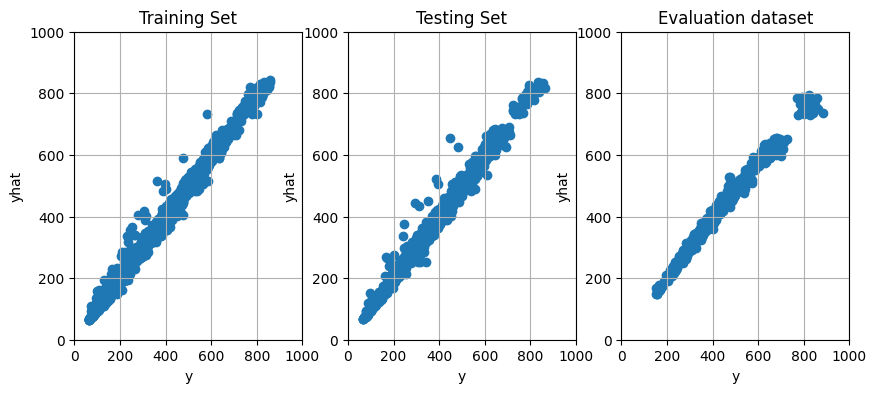

In [ ]:
#Perform XGBoost using pipelines
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report, accuracy_score

XGB = Pipeline(steps=
                   [('preprocess', preprocessor),
                   ('XGB', XGBRegressor(random_state=0))])

XGB.fit(X_train,y_train)

# Predictions on the validation set
y_pred_train = XGB.predict(X_train)
y_pred_test = XGB.predict(X_test)
y_pred_eval = XGB.predict(testing_data_X)

# Results
print('Training')
regression_results(y_train,y_pred_train)
print('Testing')
regression_results(y_test,y_pred_test)
print('Evaluation Data Set')
regression_results(testing_data_y,y_pred_eval)
#regression_results(y_test,y_pred_test)

#Two plots together

fig, ax = plt.subplots(ncols=3, figsize=(10,4))

ax[0].scatter(y_train, y_pred_train)
ax[0].set_ylim(0,1000)
ax[0].set_xlim(0,1000)
ax[0].grid()
ax[0].set_xlabel('y')
ax[0].set_ylabel('yhat')
ax[0].set_title('Training Set')


ax[1].scatter(y_test, y_pred_test)
ax[1].set_ylim(-0,1000)
ax[1].set_xlim(0,1000)
ax[1].grid()
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Testing Set')

ax[2].scatter(testing_data_y, y_pred_eval)
ax[2].set_ylim(0,1000)
ax[2].set_xlim(0,1000)
ax[2].grid()
ax[2].set_xlabel('y')
ax[2].set_ylabel('yhat')
ax[2].set_title('Evaluation dataset')
plt.show()

# Is your model's RMSE within 40 units of inventory?

Yes, our model's RMSE of 25.1826 is within 40 units of inventory.

# Please explain to the Grocery Operations team how your entire solution works to set inventory values?

The Grocery Operations team can confidently predict inventory values within 26 units of the inventory suitable for the demand on any given day using our model. We used an XGBoost model since the data was non-linear (as shown by our regression model) and XGBoost can produce high accuracy models from complex, non-linear data. Since many of the sales units values do not reflect true demand on days where units sold equals inventory units, we decided to predict those values and replace them in the dataset to create a more accurate representation of demand. These predicted values were obtained using an XGBoost model as well. Once we had a finalized demand feature, we were able to group the dataset using aggregation methods that allowed us to predict inventory levels for only the summer weeks in question. Our final model was run using the following features: 'week', 'month', 'store_size', 'store_name', and 'product_name'. Redundant features were dropped as they did not improve the value added.